#### 데이터 불러오기

In [1]:
import numpy as np
import pandas as pd
import time 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    roc_curve, 
    balanced_accuracy_score,
    classification_report, 
    confusion_matrix
)
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm


In [2]:
comp=pd.read_csv('comp.csv',encoding='cp949')

In [3]:
X = comp.drop('Intention to move into public rental housing', axis = 1)
y = comp[['Intention to move into public rental housing']]

In [4]:
X_train_valid, X_test, y_train_valid, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y   
)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_valid, y_train_valid,
    test_size=0.25,
    random_state=42,
    stratify=y_train_valid
)

In [5]:
X_train.shape[0]/X.shape[0], X_valid.shape[0]/X.shape[0], X_test.shape[0]/X.shape[0]

(0.5999871783913155, 0.1999957261304385, 0.200017095478246)

#### pycaret

In [6]:
from pycaret.classification import *

In [ ]:
train_data = pd.concat([X_train, y_train], axis=1) 
valid_data = pd.concat([X_valid, y_valid], axis=1) 

In [18]:
clf = setup(data=train_data,
            test_data = valid_data,
           target='Intention to move into public rental housing', # 종속 변수 컬럼명
           session_id=123,  # 재현성을 위한 시드 설정
           fold=10)  # 교차 검증 폴드 수

,Description,Value
0,Session id,123
1,Target,Intention to move into public rental housing
2,Target type,Binary
3,Original data shape,"(37436, 127)"
4,Transformed data shape,"(37436, 127)"
5,Transformed train set shape,"(28077, 127)"
6,Transformed test set shape,"(9359, 127)"
7,Numeric features,126
8,Preprocess,True
9,Imputation type,simple


In [19]:
# 여러 모델 비교
best_model = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.8000,0.8501,0.6092,0.7205,0.6600,0.5198,0.5236,0.5880
rf,Random Forest Classifier,0.7992,0.8493,0.5969,0.7248,0.6545,0.5149,0.5198,1.1090
et,Extra Trees Classifier,0.7987,0.8470,0.6016,0.7209,0.6557,0.5152,0.5195,1.4910
xgboost,Extreme Gradient Boosting,0.7984,0.8460,0.6163,0.7124,0.6607,0.5184,0.5213,0.3420
gbc,Gradient Boosting Classifier,0.7979,0.8413,0.6154,0.7117,0.6599,0.5173,0.5202,1.6710
lr,Logistic Regression,0.7920,0.8335,0.5866,0.7105,0.6425,0.4977,0.5024,2.6150
ridge,Ridge Classifier,0.7911,0.8319,0.5937,0.7047,0.6444,0.4981,0.5018,0.0970
ada,Ada Boost Classifier,0.7911,0.8322,0.5964,0.7034,0.6453,0.4987,0.5023,0.6860
lda,Linear Discriminant Analysis,0.7908,0.8319,0.6072,0.6974,0.6490,0.5010,0.5035,0.2330
knn,K Neighbors Classifier,0.7700,0.7750,0.5193,0.6833,0.5900,0.4343,0.4423,0.3590


In [20]:
# 최적 모델 선택 및 학습
final_model = create_model(best_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8038,0.8561,0.6480,0.7108,0.6780,0.5373,0.5385
1,0.8056,0.8505,0.6123,0.7336,0.6675,0.5317,0.5360
2,0.7977,0.8417,0.5933,0.7224,0.6515,0.5110,0.5159
3,0.8009,0.8545,0.6022,0.7264,0.6585,0.5198,0.5243
4,0.7974,0.8462,0.6045,0.7156,0.6554,0.5133,0.5170
5,0.8024,0.8559,0.6112,0.7255,0.6634,0.5250,0.5288
6,0.7974,0.8488,0.5978,0.7191,0.6528,0.5115,0.5158
7,0.7962,0.8536,0.6078,0.7111,0.6554,0.5120,0.5152
8,0.8051,0.8571,0.6235,0.7266,0.6711,0.5338,0.5369


In [21]:
# 모델 튜닝
tuned_model = tune_model(final_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8045,0.8539,0.6559,0.7089,0.6814,0.5407,0.5415
1,0.8041,0.8486,0.6168,0.7273,0.6675,0.5300,0.5336
2,0.7956,0.8378,0.5877,0.7196,0.6470,0.5052,0.5103
3,0.7977,0.8469,0.6056,0.7160,0.6562,0.5143,0.5179
4,0.7981,0.8388,0.6190,0.7103,0.6615,0.5186,0.5211
5,0.8038,0.8554,0.6279,0.7205,0.6710,0.5322,0.5347
6,0.8038,0.8469,0.6022,0.7343,0.6618,0.5255,0.5306
7,0.7962,0.8484,0.6034,0.7133,0.6538,0.5108,0.5144
8,0.8023,0.8533,0.6257,0.7179,0.6687,0.5287,0.5312


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [23]:
tuned_model

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=123, reg_alpha=0.0, reg_lambda=0.0, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

In [24]:
save_model(tuned_model, 'pycaret_model')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['Length of residence',
                                              'Housing size(㎡)', 'Age',
                                              'Number of household members',
                                              'Average monthly earned/business '
                                              'income',
                                              'Average monthly Property income',
                                              'Average monthly social insurance '
                                              'benefits',
                                              'Average monthly government '
                                              'subsidies',
                                              'Average monthly private...
                  LGBMClassifier(boosting_type='gbdt', class_weight=None,
           

In [7]:
lgbm_model = load_model('pycaret_model')

Transformation Pipeline and Model Successfully Loaded


In [8]:
lgbm_model.steps[-1][1].set_params(verbose=-1)

LGBMClassifier(n_jobs=-1, random_state=123, verbose=-1)

In [9]:
lgbm_model.fit(X_train, y_train)

Pipeline(memory=Memory(location=None),
         steps=[('numerical_imputer',
                 TransformerWrapper(include=['Length of residence',
                                             'Housing size(㎡)', 'Age',
                                             'Number of household members',
                                             'Average monthly earned/business '
                                             'income',
                                             'Average monthly Property income',
                                             'Average monthly social insurance '
                                             'benefits',
                                             'Average monthly government '
                                             'subsidies',
                                             'Average monthly private transfer '
                                             'inc...
                                             'what area do you live '
                                             'in?_Jeollanam-do',
                                             'what area do you live in?_Seoul', ...],
                                    transformer=SimpleImputer())),
                ('categorical_imputer',
                 TransformerWrapper(include=[],
                                    transformer=SimpleImputer(strategy='most_frequent'))),
                ('clean_column_names',
                 TransformerWrapper(transformer=CleanColumnNames())),
                ('trained_model',
                 LGBMClassifier(n_jobs=-1, random_state=123, verbose=-1))])

In [10]:
pred_proba = lgbm_model.predict_proba(X_test)[:, 1] # 1(positive)로 예측할 확률
pred_proba

array([0.25022452, 0.48011987, 0.91543364, ..., 0.57697047, 0.22275938,
       0.12280328])

In [11]:
# 테스트 세트에 대한 예측
y_pred = lgbm_model.predict(X_test)

In [12]:
print('\nClassification Report:')
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.88      0.86      6353
           1       0.71      0.63      0.67      3007

    accuracy                           0.80      9360
   macro avg       0.77      0.75      0.76      9360
weighted avg       0.80      0.80      0.80      9360



In [13]:
def confusion_matrix_plot(y_test, y_pred, cmap):
    plt.figure(figsize=(4,4))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

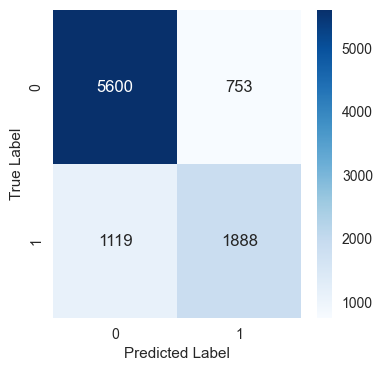

In [14]:
confusion_matrix_plot(y_test, y_pred, 'Blues')

#### 임곗값 구하기

In [15]:
fpr, tpr, thresholds = roc_curve(y_valid, lgbm_model.predict_proba(X_valid)[:,1],drop_intermediate=False)

In [16]:
i = np.arange(len(tpr))
roc = pd.DataFrame({'fpr' : pd.Series(fpr, index=i),'tpr' : pd.Series(tpr, index = i), '1-fpr' : pd.Series(1-fpr, index = i), 'tf' : pd.Series(tpr - (1-fpr), index = i), 'thresholds' : pd.Series(thresholds, index = i)})
roc.iloc[(roc.tf-0).abs().argsort()[:1]]

,fpr,tpr,1-fpr,tf,thresholds
3736,0.218322,0.78177,0.781678,0.000092,0.30549


[Text(-2000.0, 0, ''),
 Text(0.0, 0, ''),
 Text(2000.0, 0, ''),
 Text(4000.0, 0, ''),
 Text(6000.0, 0, ''),
 Text(8000.0, 0, ''),
 Text(10000.0, 0, '')]

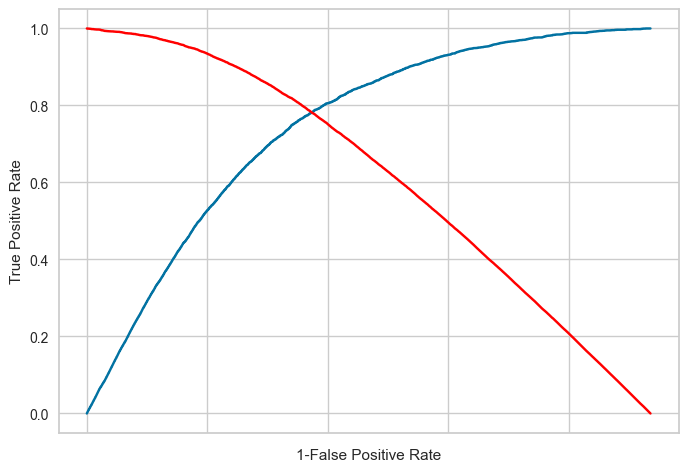

In [17]:
fig, ax = plt.subplots()
plt.plot(roc['tpr'])
plt.plot(roc['1-fpr'], color = 'red')
plt.xlabel('1-False Positive Rate')
plt.ylabel('True Positive Rate')
ax.set_xticklabels([])

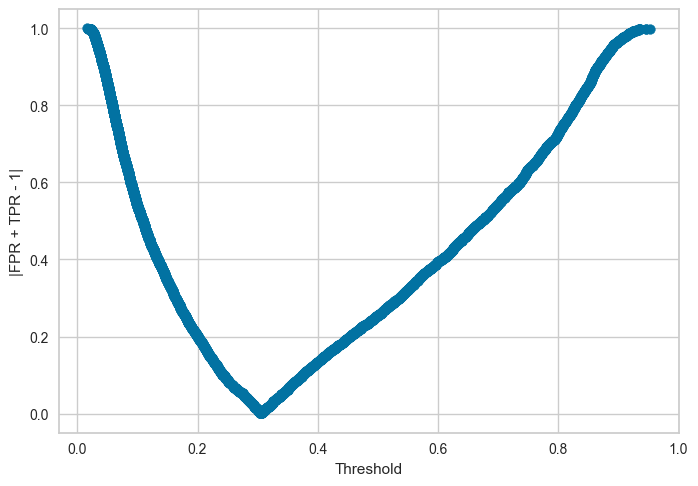

In [18]:
plt.scatter(thresholds, np.abs(fpr+tpr-1))
plt.xlabel("Threshold")
plt.ylabel("|FPR + TPR - 1|")
plt.show()

In [19]:
print('Optimal Threshold: %.16f'%(thresholds[np.argmin(np.abs(fpr+tpr-1))]))

Optimal Threshold: 0.3054898352502779


In [32]:
t1 = thresholds[np.argmin(np.abs(fpr+tpr-1))]

In [34]:
tnr = 1 - fpr
balanced_accuracy = (tpr + tnr) / 2

idx = np.argmax(balanced_accuracy)
t2 = thresholds[idx]
best_ba = balanced_accuracy[idx]

t2, best_ba

(0.33778389888363913, 0.7842486756378633)

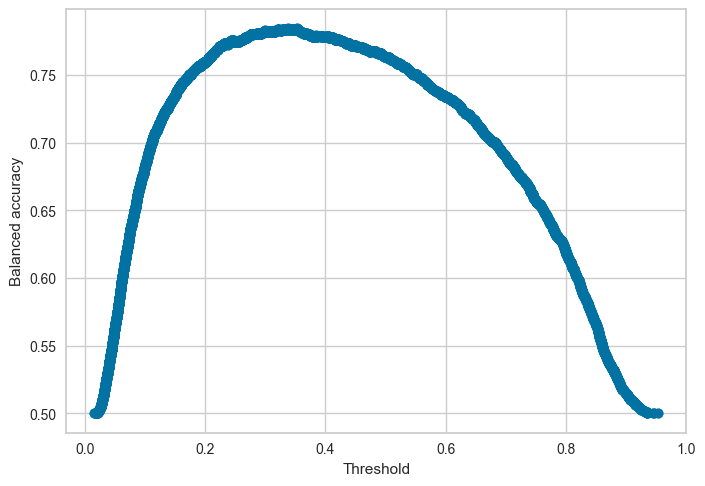

In [35]:
plt.scatter(thresholds, balanced_accuracy)
plt.xlabel("Threshold")
plt.ylabel("Balanced accuracy")
plt.show()


In [37]:
y_pred_prob = lgbm_model.predict_proba(X_test)[:, 1]
y_pred_prob

array([0.25022452, 0.48011987, 0.91543364, ..., 0.57697047, 0.22275938,
       0.12280328])

In [38]:
y_pred_t1 = (y_pred_prob >= t1).astype(int)
y_pred_t2 = (y_pred_prob >= t2).astype(int)

print('\nClassification Report:')
print(classification_report(y_test, y_pred_t1))
print(classification_report(y_test, y_pred_t2))


Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.78      0.83      6353
           1       0.62      0.78      0.69      3007

    accuracy                           0.78      9360
   macro avg       0.75      0.78      0.76      9360
weighted avg       0.80      0.78      0.78      9360

              precision    recall  f1-score   support

           0       0.87      0.80      0.83      6353
           1       0.64      0.75      0.69      3007

    accuracy                           0.78      9360
   macro avg       0.76      0.78      0.76      9360
weighted avg       0.80      0.78      0.79      9360



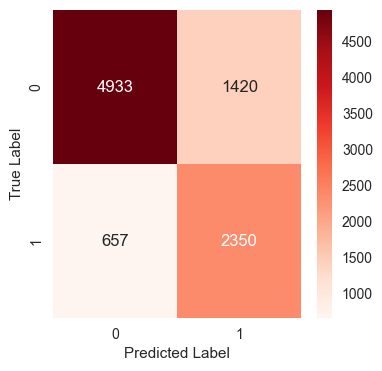

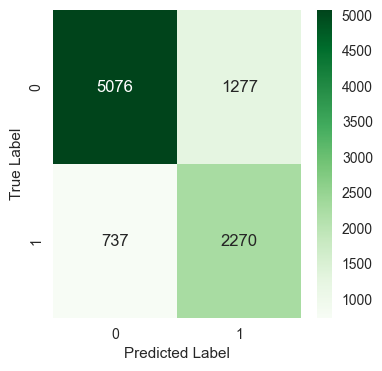

In [39]:
confusion_matrix_plot(y_test, y_pred_t1, 'Reds')
confusion_matrix_plot(y_test, y_pred_t2, 'Greens')

## 